In [ ]:
import os

cuda_device = '1'
os.environ["CUDA_VISIBLE_DEVICES"] = cuda_device

import math

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import traceback
from collections import OrderedDict
from tqdm import tqdm, trange

import random

from tensorboardX import SummaryWriter

from scipy import integrate

sns.set_style("white")
torch.cuda.is_available()

from statistics import geometric_mean

torch.set_default_dtype(torch.float64)


# parameters

In [ ]:
batch_size = 300
batch_size_LBFGS = 300

epoches = 50000
gamma = 0.99999

num_processes = 10

num_hidden = 4
width = 100

width_R = 5
num_hidden_R = 1

num_divide = 0
num_divide_LBFGS = 0

n_bic_points = 128
n_points_train = n_bic_points
n_inner_points = 128
n_points_test = 256

Adam_proportion = 0.99
coe_without_R = 0.25
coe_without_R_sidecar = 0.25

coe_without_R_new = 0.0
width_R_new = 5
coe_structure_new = 0.0001

tol = 100.0

epoches_noR = 50000
coe_without_R_noR = 0.25
num_hidden_R_noR = 2
width_R_noR = 10
coe_structure_noR = 0.0001

coe_structure = 0.001

x_l = -15.0
x_r = 15.0

t_0 = 0.0
t_T = math.pi / 2.0

def IC(x):
        return 1.0 / torch.cosh(x) * torch.cos(2 * x), -1.0 / torch.cosh(x) * torch.sin(2 * x)

C_1 = 2.0 * np.tanh(15)
C_2 = -4.0 * np.tanh(15)

def exact_solution(X):
        x = X[:,0]
        t = X[:,1]
        return 1.0 / torch.cosh(x + 2*t) * torch.cos(2*x + 3*t/2), -1.0 / torch.cosh(x + 2*t) * torch.sin(2*x + 3*t/2)

device = torch.device("cpu")

criterion = torch.nn.MSELoss()

param_vector = [50, 100, 200, 400]


In [ ]:
def setup_seed(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

class PDE_NN(nn.Module):
    def __init__(
            self,
            width,
            num_hidden,
            input_size = 2,
            hidden_size = None,
            output_size = 2,
            act = nn.Tanh,
        ):
        super(PDE_NN, self).__init__()
        if width is not None:
            hidden_size = [width] * num_hidden
        elif isinstance(hidden_size, list) and len(hidden_size) == num_hidden:
            pass  
        else:
            raise ValueError("Invalid hidden size specification")
        layers = [('input', nn.Linear(input_size, hidden_size[0]))]
        layers.append(('input_activation', act()))
        for i in range(1, num_hidden): 
            layers.append(
                ('hidden_%d' % i, nn.Linear(hidden_size[i-1], hidden_size[i]))
            )
            layers.append(('activation_%d' % i, act()))
        layers.append(('output', nn.Linear(hidden_size[-1], output_size)))
        layerDict = OrderedDict(layers)
        self.layers = nn.Sequential(layerDict)

    def forward(self, X):
        out = self.layers(X) 
        return out

class NN(nn.Module):
    def __init__(self, width, num_hidden):
        super(NN, self).__init__()
        self.PDE = PDE_NN(width, num_hidden)

    def forward(self, X):
        u = self.PDE(X)
        return u


In [ ]:
class PDE_NN_sidecar(nn.Module):
    def __init__(
            self,
            width,
            num_hidden,
            input_size = 2,
            hidden_size = None,
            output_size = 2,
            act = nn.Tanh,
        ):
        super(PDE_NN_sidecar, self).__init__()
        if width is not None:
            hidden_size = [width] * num_hidden
        elif isinstance(hidden_size, list) and len(hidden_size) == num_hidden:
            pass  
        else:
            raise ValueError("Invalid hidden size specification")
        layers = [('input', nn.Linear(input_size, hidden_size[0]))]
        layers.append(('input_activation', act()))
        for i in range(1, num_hidden): 
            layers.append(
                ('hidden_%d' % i, nn.Linear(hidden_size[i-1], hidden_size[i]))
            )
            layers.append(('activation_%d' % i, act()))
        layers.append(('output', nn.Linear(hidden_size[-1], output_size)))
        layerDict = OrderedDict(layers)
        self.layers = nn.Sequential(layerDict)

    def forward(self, X):
        out = self.layers(X) 
        return out

class structure_NN_sidecar_real(nn.Module):
    def __init__(
            self,
            width_R,
            num_hidden_R,
            input_size = 1,
            hidden_size = None,
            output_size = 1,
            act = nn.Tanh,
        ):
        super(structure_NN_sidecar_real, self).__init__()
        if width_R is not None:
            hidden_size = [width_R] * num_hidden_R
        elif isinstance(hidden_size, list) and len(hidden_size) == num_hidden_R:
            pass  
        else:
            raise ValueError("Invalid hidden size specification")
        layers = [('input', nn.Linear(input_size, hidden_size[0]))]
        layers.append(('input_activation', act()))
        for i in range(1, num_hidden_R): 
            layers.append(
                ('hidden_%d' % i, nn.Linear(hidden_size[i-1], hidden_size[i]))
            )
            layers.append(('activation_%d' % i, act()))
        layers.append(('output', nn.Linear(hidden_size[-1], output_size, bias = True)))
        layerDict = OrderedDict(layers)
        self.layers = nn.Sequential(layerDict)

    def forward(self, t):
        out = self.layers(t) 
        return out

class NN_sidecar_real(nn.Module):
    def __init__(self, width, num_hidden, width_R, num_hidden_R):
        super(NN_sidecar_real, self).__init__()
        self.PDE = PDE_NN_sidecar(width, num_hidden)
        self.structure = structure_NN_sidecar_real(width_R, num_hidden_R)

    def forward(self, X):
        v = self.PDE(X)
        R = self.structure(X[:,1].reshape(-1, 1))
        return v, R


In [ ]:
class bic_Dataset(Dataset):
    def __init__(self, n_points, x_l, x_r, t_0, t_T):
        self.n_points = n_points
        
        x_initial = torch.linspace(x_l, x_r, n_points * 4 + 1).unsqueeze(1) 
        t_initial = torch.zeros(n_points * 4 + 1, 1)
        
        t_boundary = torch.linspace(t_0, t_T, n_points).unsqueeze(1)
        x_boundary = torch.full((n_points, 1), x_l)
        
        self.x = torch.cat([x_initial, x_boundary], dim=0)
        self.t = torch.cat([t_initial, t_boundary], dim=0)
        self.labels = torch.cat([torch.ones(n_points * 4 + 1), torch.full((n_points,), 2)], dim=0).long()

    def __len__(self):
        return 4 * self.n_points

    def __getitem__(self, idx):
        return self.x[idx], self.t[idx], self.labels[idx]


In [8]:
def gradient(func,var,order = 1):
    if order == 1:
        return torch.autograd.grad(inputs = var, 
                                    outputs = func,
                                    grad_outputs=torch.ones_like(func),
                                    create_graph=True,
                                    only_inputs=True)[0]
    else:
        out = gradient(func,var)
        return gradient(out,var,order - 1)

In [ ]:
def loss_fn_PINNs(model, X, x_inner, t_inner, x, t, labels, epoch):
        if
        if len(x[labels == 2]) == 0:
            loss_bc = torch.tensor(0.0, requires_grad=True).to(device)
        else:
            x_bc1 = torch.full_like(x[labels == 2], x_l, requires_grad=True)
            x_bc2 = torch.full_like(x[labels == 2], x_r, requires_grad=True)
            t_bc = t[labels == 2]
            u_pred_bc1 = model(torch.cat([x_bc1, t_bc], dim=1))
            u_pred_bc2 = model(torch.cat([x_bc2, t_bc], dim=1))
            u_pred_bc1_re, u_pred_bc1_im = torch.unbind(u_pred_bc1, dim=1)
            u_pred_bc2_re, u_pred_bc2_im = torch.unbind(u_pred_bc2, dim=1)
            du_dx_bc1_re = gradient(u_pred_bc1_re, x_bc1)[:, 0]
            du_dx_bc1_im = gradient(u_pred_bc1_im, x_bc1)[:, 0]
            du_dx_bc2_re = gradient(u_pred_bc2_re, x_bc2)[:, 0]
            du_dx_bc2_im = gradient(u_pred_bc2_im, x_bc2)[:, 0]
            loss_bc = criterion(u_pred_bc1_re, u_pred_bc2_re) + criterion(u_pred_bc1_im, u_pred_bc2_im) + criterion(du_dx_bc1_re, du_dx_bc2_re) + criterion(du_dx_bc1_im, du_dx_bc2_im)
        if len(x[labels == 1]) == 0:
            loss_ic = torch.tensor(0.0, requires_grad=True).to(device)
        else:
            X_ic = torch.cat([x[labels == 1], t[labels == 1]], dim=1)
            u_pred_ic = model(X_ic)
            u_pred_ic_re, u_pred_ic_im = torch.unbind(u_pred_ic, dim=1)
            u_ic_re, u_ic_im = IC(X_ic[:, 0])
            loss_ic = criterion(u_pred_ic_re, u_ic_re) + criterion(u_pred_ic_im, u_ic_im)
        loss_data = loss_bc + loss_ic
        u_pred = model(X)
        u_pred_re, u_pred_im = torch.unbind(u_pred, dim=1)
        du_dX_re = gradient(u_pred_re, X)
        du_dX_im = gradient(u_pred_im, X)
        du_dt_re = du_dX_re[:, 1]
        du_dt_im = du_dX_im[:, 1]
        du_dx_re = du_dX_re[:, 0]
        du_dx_im = du_dX_im[:, 0]
        du_dxx_re = gradient(du_dx_re, X)[:, 0]
        du_dxx_im = gradient(du_dx_im, X)[:, 0]
        u_norm_square = u_pred_re**2 + u_pred_im**2
        loss_re = criterion(-du_dt_im + 0.5 * du_dxx_re + u_norm_square * u_pred_re, torch.zeros(u_pred_re.size()).to(device))
        loss_im = criterion(du_dt_re + 0.5 * du_dxx_im + u_norm_square * u_pred_im, torch.zeros(u_pred_re.size()).to(device))
        loss_pde = loss_re + loss_im
        h = x_inner[1] - x_inner[0]
        momentum_temp = u_pred_re * du_dx_im - u_pred_im * du_dx_re
        momentum_temp_matrix = momentum_temp.reshape(len(x_inner), len(t_inner)).detach().cpu().numpy()
        temp = integrate.romb(momentum_temp_matrix.T, dx = h.cpu().numpy())
        loss_energy = np.max(np.abs(temp - C_2))
        u_exact_re, u_exact_im = exact_solution(X)
        diff_square = (u_pred_re - u_exact_re)**2 + (u_pred_im - u_exact_im)**2
        loss_exact = torch.sqrt(torch.mean(diff_square))
        u_square = u_pred_re ** 2 + u_pred_im ** 2
        u_square_matrix = u_square.reshape(len(x_inner), len(t_inner)).detach().cpu().numpy()
        temp = integrate.romb(u_square_matrix.T, dx=h.cpu().numpy())
        loss_mass = np.max(np.abs(temp - C_1))
        loss = loss_pde + loss_data
        return loss, loss_pde, loss_data, loss_energy, loss_exact, loss_mass


In [ ]:
def loss_fn_real(model, X, x_inner, t_inner, x, t, labels, epoch):
    if len(x[labels == 2]) == 0:
        loss_bc = torch.tensor(0.0, requires_grad=True).to(device)
    else:
        x_bc1 = torch.full_like(x[labels == 2], x_l, requires_grad=True)
        x_bc2 = torch.full_like(x[labels == 2], x_r, requires_grad=True)
        t_bc = t[labels == 2]
        v_pred_bc1, R_bc1 = model(torch.cat([x_bc1, t_bc], dim=1))
        v_pred_bc2, R_bc2 = model(torch.cat([x_bc2, t_bc], dim=1))
        u_pred_bc1_re, u_pred_bc1_im = torch.unbind(v_pred_bc1 * R_bc1, dim=1)
        u_pred_bc2_re, u_pred_bc2_im = torch.unbind(v_pred_bc2 * R_bc2, dim=1)
        du_dx_bc1_re = gradient(u_pred_bc1_re, x_bc1)[:, 0]
        du_dx_bc1_im = gradient(u_pred_bc1_im, x_bc1)[:, 0]
        du_dx_bc2_re = gradient(u_pred_bc2_re, x_bc2)[:, 0]
        du_dx_bc2_im = gradient(u_pred_bc2_im, x_bc2)[:, 0]
        loss_bc = criterion(u_pred_bc1_re, u_pred_bc2_re) + criterion(u_pred_bc1_im, u_pred_bc2_im) + criterion(du_dx_bc1_re, du_dx_bc2_re) + criterion(du_dx_bc1_im, du_dx_bc2_im)
    if len(x[labels == 1]) == 0:
        loss_ic = torch.tensor(0.0, requires_grad=True).to(device)
    else:
        X_ic = torch.cat([x[labels == 1], t[labels == 1]], dim=1)
        u_pred_ic, R_ic = model(X_ic)
        u_pred_ic_re, u_pred_ic_im = torch.unbind(u_pred_ic * R_ic, dim=1)
        u_ic_re, u_ic_im = IC(X_ic[:, 0])
        loss_ic = criterion(u_pred_ic_re, u_ic_re) + criterion(u_pred_ic_im, u_ic_im)
    loss_data = loss_bc + loss_ic
    v_pred, R = model(X)
    u_pred_re, u_pred_im = torch.unbind(v_pred * R, dim=1)
    du_dX_re = gradient(u_pred_re, X)
    du_dX_im = gradient(u_pred_im, X)
    du_dt_re = du_dX_re[:, 1]
    du_dt_im = du_dX_im[:, 1]
    du_dx_re = du_dX_re[:, 0]
    du_dx_im = du_dX_im[:, 0]
    du_dxx_re = gradient(du_dx_re, X)[:, 0]
    du_dxx_im = gradient(du_dx_im, X)[:, 0]
    u_norm_square = u_pred_re**2 + u_pred_im**2
    loss_re = criterion(-du_dt_im + 0.5 * du_dxx_re + u_norm_square * u_pred_re, torch.zeros(u_pred_re.size()).to(device))
    loss_im = criterion(du_dt_re + 0.5 * du_dxx_im + u_norm_square * u_pred_im, torch.zeros(u_pred_re.size()).to(device))
    loss_pde = loss_re + loss_im
    loss_structure = 0.0
    h = x_inner[1] - x_inner[0]
    momentum_temp = u_pred_re * du_dx_im - u_pred_im * du_dx_re
    momentum_temp_matrix = momentum_temp.reshape(len(x_inner), len(t_inner)).detach().cpu().numpy()
    temp = integrate.romb(momentum_temp_matrix.T, dx = h.cpu().numpy())
    loss_energy_vector = np.abs(temp - C_2)
    loss_energy = np.max(loss_energy_vector)
    u_exact_re, u_exact_im = exact_solution(X)
    diff_square = (u_pred_re - u_exact_re)**2 + (u_pred_im - u_exact_im)**2
    loss_exact = torch.sqrt(torch.mean(diff_square))
    u_square = u_pred_re ** 2 + u_pred_im ** 2
    u_square_matrix = u_square.reshape(len(x_inner), len(t_inner)).detach().cpu().numpy()
    temp = integrate.romb(u_square_matrix.T, dx=h.cpu().numpy())
    loss_mass = np.max(np.abs(temp - C_1))
    loss = loss_pde + loss_data + coe_structure * loss_structure
    return loss, loss_pde, loss_data, loss_energy, loss_exact, loss_structure, loss_mass


In [ ]:
x_test = torch.linspace(x_l, x_r, n_points_test * 4 + 1)
t_test = torch.linspace(t_0, t_T, n_points_test)

X_test = torch.stack(torch.meshgrid(x_test, t_test, indexing='ij')).reshape(2, -1).T
X_test = X_test.to(device)
X_test.requires_grad = True

x_ic_test = x_test.unsqueeze(1)
t_ic_test = torch.zeros(n_points_test * 4 + 1, 1)

t_bc_test = t_test.unsqueeze(1)
x_bc_test = torch.full((n_points_test, 1), x_l)

x = torch.cat([x_ic_test, x_bc_test], dim=0).to(device)
t = torch.cat([t_ic_test, t_bc_test], dim=0).to(device)
labels = torch.cat([torch.ones(n_points_test * 4 + 1), torch.full((n_points_test,), 2)], dim=0).long().to(device)


In [12]:
import scipy

def geometric_mean_and_confidence_interval(data, confidence=0.95):
    """
    Calculate the geometric mean and confidence interval for a given dataset.

    Parameters:
    - data (numpy.ndarray): The input data, shape (n_samples, n_features) or 1D array.
    - confidence (float): The confidence level for the interval (default is 0.95 for 95% confidence).

    Returns:
    - geometric_mean (numpy.ndarray): The geometric mean for the dataset.
    - lower_bound (numpy.ndarray): The lower bound of the confidence interval.
    - upper_bound (numpy.ndarray): The upper bound of the confidence interval.
    """
    # Ensure the data is in a numpy array
    data = np.asarray(data)

    # Avoid log(0) issues by adding a small epsilon
    epsilon = 1e-10
    data = np.clip(data, epsilon, None)

    # Transform data to log space
    log_data = np.log(data)

    # Calculate the mean and standard error in log space
    log_mean = np.mean(log_data, axis=0)  # Mean in log space
    log_std = np.std(log_data, axis=0, ddof=1)  # Standard deviation in log space
    n = log_data.shape[0]  # Number of samples
    log_sem = log_std / np.sqrt(n)  # Standard error of the mean

    # Determine t-value for the confidence interval
    t_value = scipy.stats.t.ppf((1 + confidence) / 2., df=n-1)

    # Calculate the confidence interval in log space
    log_ci_upper = log_mean + t_value * log_sem
    log_ci_lower = log_mean - t_value * log_sem

    # Convert back to original space using the exponential function
    geometric_mean = np.exp(log_mean)
    lower_bound = np.exp(log_ci_lower)
    upper_bound = np.exp(log_ci_upper)

    return geometric_mean, lower_bound, upper_bound

# load

In [ ]:
learning_rate = 0.00001

coe_without_R = 1.0

width_R = 5

num_hidden_R = 2

epoches = 120000

batch_size = 2046

i = 0

result_matrix_PINNs = np.zeros((len(param_vector), num_processes, 6))

for width in param_vector:

    if num_divide_LBFGS != 0:
        width_R = int(width/num_divide)

    for j in range(num_processes):

        model = NN(width + width_R, num_hidden).to(device)

        model.load_state_dict(torch.load(f"/home/22040517r/sidecar/Sidecar/codes/NLS/parallel/moving/PINNs_float64/trained_model/NLS-Original-bs{batch_size}-epoches{epoches}-width{width + width_R}-n_bic{n_bic_points}-n_inner{n_inner_points}-gamma{gamma}-{j}.pth", map_location=device))

        model.eval()

        loss_vector = loss_fn_PINNs(model, X_test, x_test, t_test, x, t, labels, epoches)

        result_matrix_PINNs[i, j, :] = torch.tensor(loss_vector)

        del model

    i += 1


In [ ]:
results = result_matrix_PINNs

print(results)

first_component = results[..., 1] + results[..., 2]

print(first_component)

min_errors_PINNs = np.min(first_component, axis=1)
min_errors_positions = np.argmin(first_component, axis=1)

min_errors_PINNs_PDE = results[np.arange(len(param_vector)), min_errors_positions, 1]
min_errors_PINNs_data = results[np.arange(len(param_vector)), min_errors_positions, 2]
min_errors_PINNs_energy = results[np.arange(len(param_vector)), min_errors_positions, 3]
min_errors_PINNs_exact = results[np.arange(len(param_vector)), min_errors_positions, 4]
min_errors_PINNs_mass = results[np.arange(len(param_vector)), min_errors_positions, 5]

lower_bound_PINNs = np.zeros([int(len(param_vector))])
lower_bound_energy_PINNs = np.zeros([int(len(param_vector))])
lower_bound_exact_PINNs = np.zeros([int(len(param_vector))])
lower_bound_mass_PINNs = np.zeros([int(len(param_vector))])

upper_bound_PINNs = np.zeros([int(len(param_vector))])
upper_bound_energy_PINNs = np.zeros([int(len(param_vector))])
upper_bound_exact_PINNs = np.zeros([int(len(param_vector))])
upper_bound_mass_PINNs = np.zeros([int(len(param_vector))])

mean_errors_PINNs = np.zeros([int(len(param_vector))])
mean_errors_PINNs_PDE = np.zeros([int(len(param_vector))])
mean_errors_PINNs_data = np.zeros([int(len(param_vector))])
mean_energy_errors_PINNs = np.zeros([int(len(param_vector))])
mean_exact_errors_PINNs = np.zeros([int(len(param_vector))])
mean_mass_errors_PINNs = np.zeros([int(len(param_vector))])

median_errors_PINNs = np.zeros([int(len(param_vector))])
median_errors_PINNs_PDE = np.zeros([int(len(param_vector))])
median_errors_PINNs_data = np.zeros([int(len(param_vector))])

for i in range(len(param_vector)):
    print(first_component[i,:])
    mean_errors_PINNs[i], lower_bound_PINNs[i], upper_bound_PINNs[i] = geometric_mean_and_confidence_interval(first_component[i,:])
    mean_energy_errors_PINNs[i], lower_bound_energy_PINNs[i], upper_bound_energy_PINNs[i] = geometric_mean_and_confidence_interval(results[i,:,3])
    mean_exact_errors_PINNs[i], lower_bound_exact_PINNs[i], upper_bound_exact_PINNs[i] = geometric_mean_and_confidence_interval(results[i,:,4])
    mean_mass_errors_PINNs[i], lower_bound_mass_PINNs[i], upper_bound_mass_PINNs[i] = geometric_mean_and_confidence_interval(results[i,:,5])
    median_errors_PINNs[i] = np.median(first_component[i,:])
    median_errors_PINNs_PDE[i] = np.median(results[i,:,1])
    median_errors_PINNs_data[i] = np.median(results[i,:,2])


In [ ]:
epoches = 20000
gamma = 0.9999
learning_rate = 0.00001

coe_without_R = 1.0

width_R = 10

num_hidden_R = 2

batch_size = 2046

i = 0

result_matrix_sidecar_LBFGS_real = np.zeros((len(param_vector), num_processes, 7))

for width in param_vector:

    if num_divide_LBFGS != 0:
        width_R = int(width/num_divide)

    for j in range(num_processes):

        model = NN_sidecar_real(width, num_hidden, width_R, num_hidden_R).to(device)

        model.load_state_dict(torch.load(f"/home/22040517r/sidecar/Sidecar/codes/NLS/parallel/momentum/sidecar_after_real/trained_model/NLS-after-romb-lr{learning_rate}-bs{batch_size}-epoches{epoches}-width{width}-depth{num_hidden}-widthR{width_R}-depthR{num_hidden_R}-n_bic{n_bic_points}-n_inner{n_inner_points}-coeR{coe_without_R}-gamma{gamma}-{j}.pth", map_location=device))


        model.eval()

        loss_vector = loss_fn_real(model, X_test, x_test, t_test, x, t, labels, epoches)

        result_matrix_sidecar_LBFGS_real[i, j, :] = torch.tensor(loss_vector)

        del model

    i += 1



In [ ]:
results = result_matrix_sidecar_LBFGS_real

print(results)

first_component = results[..., 1] + results[..., 2]

print(first_component)

min_errors_sidecar_LBFGS_real = np.min(first_component, axis=1)
min_errors_positions = np.argmin(first_component, axis=1)

min_errors_sidecar_LBFGS_real_PDE = results[np.arange(len(param_vector)), min_errors_positions, 1]
min_errors_sidecar_LBFGS_real_data = results[np.arange(len(param_vector)), min_errors_positions, 2]
min_errors_sidecar_LBFGS_real_energy = results[np.arange(len(param_vector)), min_errors_positions, 3]
min_errors_sidecar_LBFGS_real_exact = results[np.arange(len(param_vector)), min_errors_positions, 4]
min_errors_sidecar_LBFGS_real_mass = results[np.arange(len(param_vector)), min_errors_positions, 6]

mean_errors_sidecar_LBFGS_real = np.zeros([int(len(param_vector))])
mean_errors_sidecar_LBFGS_real_PDE = np.zeros([int(len(param_vector))])
mean_errors_sidecar_LBFGS_real_data = np.zeros([int(len(param_vector))])
mean_energy_errors_sidecar_LBFGS_real = np.zeros([int(len(param_vector))])
mean_exact_errors_sidecar_LBFGS_real = np.zeros([int(len(param_vector))])
mean_mass_errors_sidecar_LBFGS_real = np.zeros([int(len(param_vector))])

lower_bound_sidecar_LBFGS_real = np.zeros([int(len(param_vector))])
lower_bound_energy_sidecar_LBFGS_real = np.zeros([int(len(param_vector))])
lower_bound_exact_sidecar_LBFGS_real = np.zeros([int(len(param_vector))])
lower_bound_mass_sidecar_LBFGS_real = np.zeros([int(len(param_vector))])

upper_bound_sidecar_LBFGS_real = np.zeros([int(len(param_vector))])
upper_bound_energy_sidecar_LBFGS_real = np.zeros([int(len(param_vector))])
upper_bound_exact_sidecar_LBFGS_real = np.zeros([int(len(param_vector))])
upper_bound_mass_sidecar_LBFGS_real = np.zeros([int(len(param_vector))])

median_errors_sidecar_LBFGS_real = np.zeros([int(len(param_vector))])
median_errors_sidecar_LBFGS_real_PDE = np.zeros([int(len(param_vector))])
median_errors_sidecar_LBFGS_real_data = np.zeros([int(len(param_vector))])

for i in range(len(param_vector)):
    print(first_component[i,:])
    mean_errors_sidecar_LBFGS_real[i], lower_bound_sidecar_LBFGS_real[i], upper_bound_sidecar_LBFGS_real[i] = geometric_mean_and_confidence_interval(first_component[i,:])
    mean_energy_errors_sidecar_LBFGS_real[i], lower_bound_energy_sidecar_LBFGS_real[i], upper_bound_energy_sidecar_LBFGS_real[i] = geometric_mean_and_confidence_interval(results[i,:,3])
    mean_exact_errors_sidecar_LBFGS_real[i], lower_bound_exact_sidecar_LBFGS_real[i], upper_bound_exact_sidecar_LBFGS_real[i] = geometric_mean_and_confidence_interval(results[i,:,4])
    mean_mass_errors_sidecar_LBFGS_real[i], lower_bound_mass_sidecar_LBFGS_real[i], upper_bound_mass_sidecar_LBFGS_real[i] = geometric_mean_and_confidence_interval(results[i,:,6])
    median_errors_sidecar_LBFGS_real[i] = np.median(first_component[i,:])
    median_errors_sidecar_LBFGS_real_PDE[i] = np.median(results[i,:,1])
    median_errors_sidecar_LBFGS_real_data[i] = np.median(results[i,:,2])


# plot

In [18]:
from statistics import geometric_mean

from matplotlib.ticker import FixedLocator, NullFormatter, LogLocator, FixedFormatter, FuncFormatter

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['font.family'] = 'Times New Roman'
mpl.rcParams['mathtext.fontset'] = 'cm'

x = np.array(param_vector)

index = param_vector 



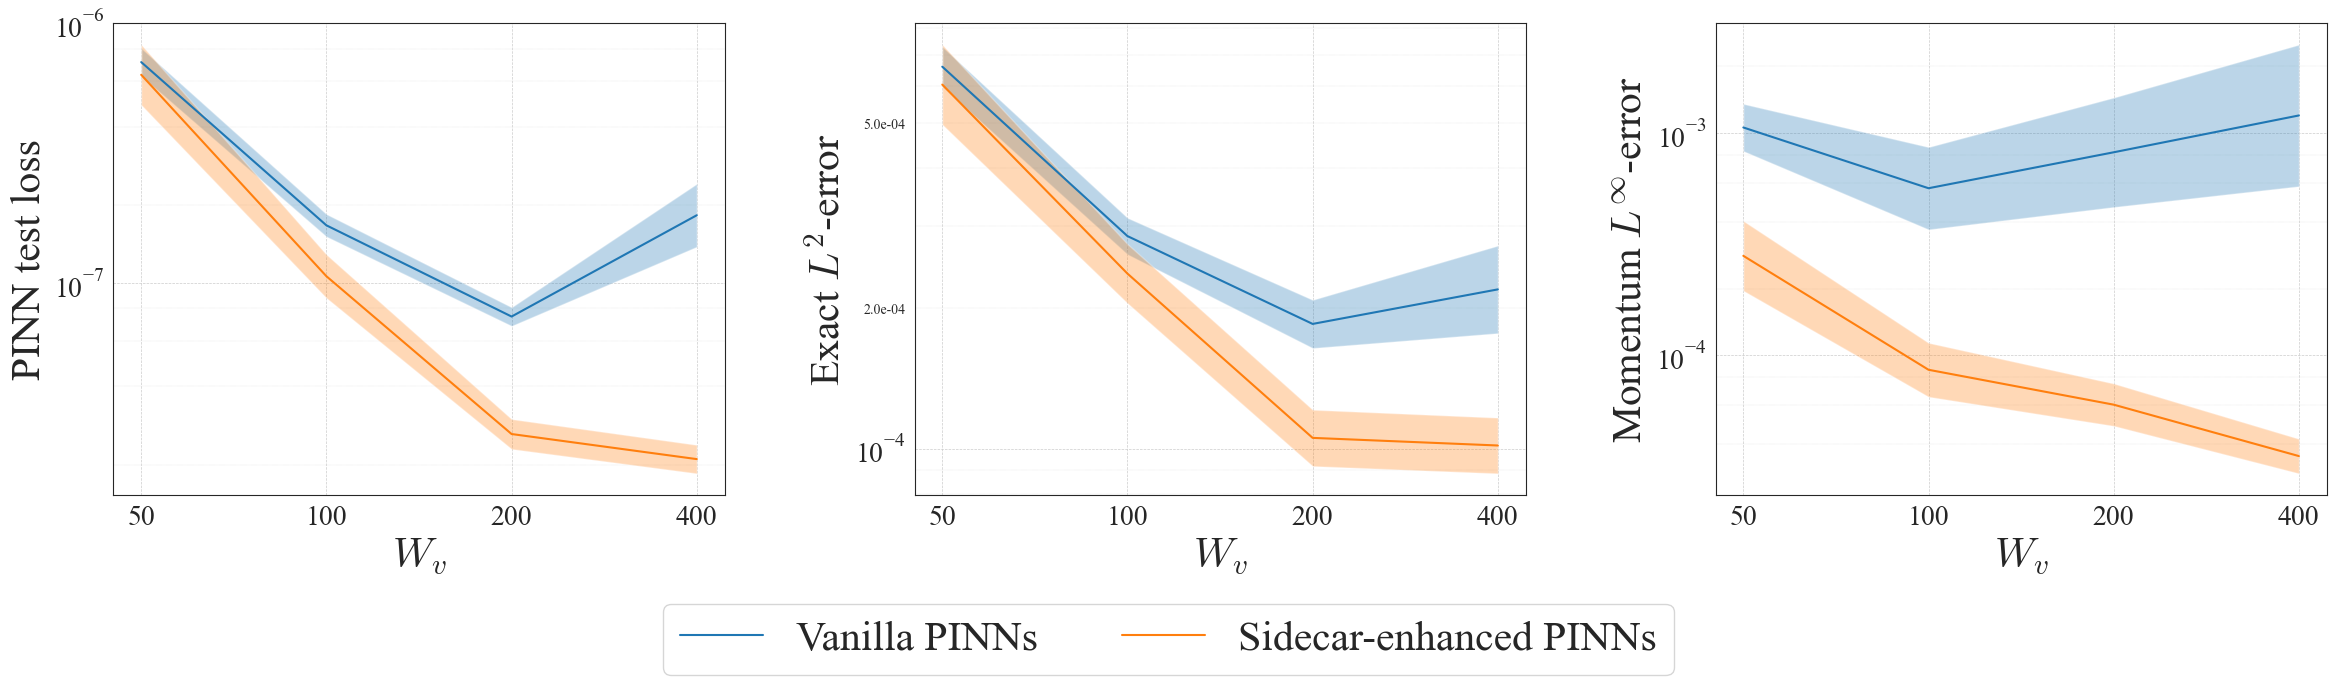

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator, FixedFormatter, NullFormatter, LogLocator

fig, axes = plt.subplots(1, 3, figsize=(24, 6.5))

ticks = x
labels = ['50', '100', '200', '400']

axes[0].plot(x, mean_errors_PINNs, label='Vanilla PINNs')
axes[0].fill_between(x, lower_bound_PINNs, upper_bound_PINNs, alpha=0.3)
axes[0].plot(x, mean_errors_sidecar_LBFGS_real, label='Sidecar-enhanced PINNs')
axes[0].fill_between(x, lower_bound_sidecar_LBFGS_real, upper_bound_sidecar_LBFGS_real, alpha=0.3)
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_xticks(ticks)
axes[0].set_xticklabels(labels)
axes[0].set_xlabel('$W_v$', size=30)
axes[0].set_ylabel('PINN test loss', size=30)
axes[0].xaxis.set_minor_formatter(NullFormatter())
axes[0].legend(fontsize=30)
axes[0].tick_params(axis='x', which='major', labelsize=20)
axes[0].tick_params(axis='y', which='major', labelsize=20)
axes[0].yaxis.set_minor_locator(LogLocator(base=10.0, subs=[0.2, 0.4, 0.6, 0.8], numticks=100))
axes[0].grid(True, which='major', axis='y', linestyle='--', linewidth=0.5)
axes[0].grid(True, which='minor', axis='y', linestyle=':', linewidth=0.3)
axes[0].grid(True, which='major', axis='x', linestyle='--', linewidth=0.5)

axes[1].plot(x, mean_exact_errors_PINNs, label='$\mathcal{L}_{Solver}$')
axes[1].fill_between(x, lower_bound_exact_PINNs, upper_bound_exact_PINNs, alpha=0.3)
axes[1].plot(x, mean_exact_errors_sidecar_LBFGS_real, label='$\mathcal{L}_{Solver} + \mathcal{L}_R$')
axes[1].fill_between(x, lower_bound_exact_sidecar_LBFGS_real, upper_bound_exact_sidecar_LBFGS_real, alpha=0.3)
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_xticks(ticks)
axes[1].set_xticklabels(labels)
axes[1].set_xlabel('$W_v$', size=30)
axes[1].set_ylabel('Exact $L^2$-error', size=30)
axes[1].xaxis.set_minor_formatter(NullFormatter())
axes[1].tick_params(axis='x', which='major', labelsize=20)
axes[1].tick_params(axis='y', which='major', labelsize=20)
axes[1].yaxis.set_minor_locator(LogLocator(base=10.0, subs=[0.2, 0.4, 0.6, 0.8], numticks=100))
axes[1].grid(True, which='major', axis='y', linestyle='--', linewidth=0.5)
axes[1].grid(True, which='minor', axis='y', linestyle=':', linewidth=0.3)
axes[1].grid(True, which='major', axis='x', linestyle='--', linewidth=0.5)

axes[2].plot(x, mean_energy_errors_PINNs, label='$\mathcal{L}_{Solver}$')
axes[2].fill_between(x, lower_bound_energy_PINNs, upper_bound_energy_PINNs, alpha=0.3)
axes[2].plot(x, mean_energy_errors_sidecar_LBFGS_real, label='$\mathcal{L}_{Solver} + \mathcal{L}_R$')
axes[2].fill_between(x, lower_bound_energy_sidecar_LBFGS_real, upper_bound_energy_sidecar_LBFGS_real, alpha=0.3)
axes[2].set_xscale('log')
axes[2].set_yscale('log')
axes[2].set_xticks(ticks)
axes[2].set_xticklabels(labels)
axes[2].set_xlabel('$W_v$', size=30)
axes[2].set_ylabel('Momentum $L^\infty$-error', size=30)
axes[2].tick_params(axis='x', which='major', labelsize=20)
axes[2].tick_params(axis='y', which='major', labelsize=20)
axes[2].xaxis.set_minor_formatter(NullFormatter())
axes[2].yaxis.set_minor_locator(LogLocator(base=10.0, subs=[0.2, 0.4, 0.6, 0.8], numticks=100))
axes[2].grid(True, which='major', axis='y', linestyle='--', linewidth=0.5)
axes[2].grid(True, which='minor', axis='y', linestyle=':', linewidth=0.3)
axes[2].grid(True, which='major', axis='x', linestyle='--', linewidth=0.5)

plt.tight_layout(pad=3.0)

handles, labels = [], []
for ax in [axes[0]]:
    h, l = ax.get_legend_handles_labels()
    handles.extend(h)
    labels.extend(l)
    ax.legend().remove()

def selective_minor_formatter(x, pos):
    if x <= 0:
        return ""
    log_val = np.log10(x)
    power = int(np.floor(log_val))
    mantissa = x / (10 ** power)
    target_multiples = [2, 5]
    for target in target_multiples:
        if abs(mantissa - target) < 0.1:
            return f"{x:.1e}"
    return ""

def setup_y_grid_and_selective_labels(ax):
    ax.yaxis.set_minor_locator(LogLocator(base=10.0, subs=[0.2, 0.4, 0.6, 0.8], numticks=100))
    ax.yaxis.set_minor_formatter(FuncFormatter(selective_minor_formatter))
    ax.grid(True, which='major', axis='y', linestyle='--', linewidth=0.5)
    ax.grid(True, which='minor', axis='y', linestyle=':', linewidth=0.3)
    ax.grid(True, which='major', axis='x', linestyle='--', linewidth=0.5)
    ax.tick_params(axis='y', which='minor', labelsize=10, length=3)
    ax.minorticks_on()

for i in [1]:
    setup_y_grid_and_selective_labels(axes[i])

fig.legend(handles, labels, loc='lower center', ncol=3, fontsize=30, bbox_to_anchor=(0.5, -0.12))

plt.savefig('/home/22040517r/sidecar/Sidecar/codes/NLS/parallel/momentum/NLS2_combined.pdf', bbox_inches='tight')
plt.show()
